## Setup

In [1]:
# can take around 30s
%%capture
! pip install datasets #huggingface datasets library
! pip install --upgrade pyarrow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# hugging face imports
from datasets import load_dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import sys
import warnings

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# assert device=='cuda', "you need to change runtime type to GPU"

In [4]:
# hyperparams and helper functions
SMALL_ITERS = 1000
LARGE_ITERS = 2000
context_window_size = 256
chunk_size = 512 # BERT can only take max input size 512 characters

def chunk_string(string, size):
    """
    Splits a string into chunks of a specified size.

    :param string: The string to be chunked.
    :param size: The desired chunk size.
    :return: A list of string chunks.
    """
    return [string[i:i+size] for i in range(0, len(string), size)]

## Data Preprocessing

As in the previous problem sets, a certain amount of preprocessing for textual data is required.

### 0.1: Loading the dataset

The first step is to actually download the dataset. We will be using a dataset on [huggingface](https://huggingface.co/). You can think of hugging face as the sklearn of deep learning.

The dominant mode for preprocessing textual data is to tokenize it, that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionary where counting numbers map to tokens. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research. For our baseline, we will use a tokenizer that microsoft created for code.

In [5]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/CodeBERT-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [6]:
# Load the concatenated data
raw_data = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2024/assignments/hw4/python_corpus_4M.csv", header=None)

In [7]:
raw_data.shape

(1172, 1)

In [8]:
print(raw_data.iloc[60].values)

['"""\nReads climate modeling grid 0.05 degree MCD43 BRDF files.\n\n"""\n\nimport os\nimport sys\nfrom numpy    import loadtxt, array, tile, where, concatenate, flipud\nfrom numpy import ones\nfrom datetime import date, datetime, timedelta\nfrom glob     import glob\nfrom pyhdf.SD import SD, HDF4Error\n\nMISSING = 32.767\n\n\nSDS = dict (\n      LAND = (\'BRDF_Albedo_Parameter1_Band1\',\'BRDF_Albedo_Parameter1_Band2\',\n              \'BRDF_Albedo_Parameter1_Band3\',\'BRDF_Albedo_Parameter1_Band4\',\n              \'BRDF_Albedo_Parameter1_Band5\',\'BRDF_Albedo_Parameter1_Band6\',\n              \'BRDF_Albedo_Parameter1_Band7\',\n              \'BRDF_Albedo_Parameter2_Band1\',\'BRDF_Albedo_Parameter2_Band2\',\n              \'BRDF_Albedo_Parameter2_Band3\',\'BRDF_Albedo_Parameter2_Band4\',\n              \'BRDF_Albedo_Parameter2_Band5\',\'BRDF_Albedo_Parameter2_Band6\',\n              \'BRDF_Albedo_Parameter2_Band7\',\n              \'BRDF_Albedo_Parameter3_Band1\',\'BRDF_Albedo_Paramet

In [9]:
# should take around 3 min to load in around 4M tokens
warnings.filterwarnings("ignore")

tokens = torch.tensor([], dtype=torch.long)
for index, row in raw_data.iterrows():
    text = row[0]
    chunks = chunk_string(text, chunk_size)
    n = len(chunks)
    for idx, chunk in enumerate(chunks):
        new_tokens = torch.tensor(tokenizer.encode(chunk, add_special_tokens=True))

        # logic to avoid incorrectly adding in start and end sequence tokens as an artifact of chunking
        if idx == 0:
            tokens = torch.cat((tokens, new_tokens[:-1]), dim=0)
        elif idx == n-1:
            tokens = torch.cat((tokens, new_tokens[1:]), dim=0)
        else:
            tokens = torch.cat((tokens, new_tokens[1:-1]), dim=0)

print(f"{len(tokens)} tokens have been loaded in")

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


4000596 tokens have been loaded in


### Question 0.2: Examining the tokenizer

Let's see what the tokens look like! We will use these two prompts during the assignment.

In [10]:
prompt_1_text = \
"""def newton(eta, N, X, y, gamma, beta=None):
  \"""
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  \"""

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):"""

In [11]:
prompt_2_text = \
"""import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    \"""Performs L2-Norm.\"""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    \"""Computes Euclidean distance.\"""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):"""

Here is what the tokenized output for the prompts looks like

In [12]:
tokenizer.decode(tokenizer.encode(prompt_1_text))

'<s>def newton(eta, N, X, y, gamma, beta=None):\n  """\n  Performs Newton\'s method on the negative average log likelihood with an\n  l2 regularization term\n\n  beta: torch.Tensor, of shape (teams)\n  X: torch.Tensor, the covariate matrix, of shape (-1, teams)\n  y: torch.Tensor, the response vector, of shape (teams)\n  gamma: float, the scale parameter for the regularization\n  beta: torch.Tensor, the starting point for gradient descent, if specified\n  """\n\n  if beta is None:\n    # Instantiate the beta vector at a random point\n    beta = torch.randn(X.shape[1])\n  else:\n    beta = torch.clone(beta)\n\n  loss = []\n\n  # Instantiate a list to store the loss throughout the gradient descent\n  # path\n  for i in tqdm(range(N)):</s>'

In [13]:
tokenizer.decode(tokenizer.encode(prompt_2_text))

'<s>import torch\nimport torch.nn.functional as F\n\n\ndef normalize(x, axis=-1):\n    """Performs L2-Norm."""\n    num = x\n    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12\n    return num / denom\n\ndef euclidean_dist(x, y):\n    """Computes Euclidean distance."""\n    m, n = x.size(0), y.size(0)\n    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)\n    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()\n    dist = xx + yy - 2 * torch.matmul(x, y.t())\n\n    dist = dist.clamp(min=1e-12).sqrt()\n\n    return dist\n\n\ndef cosine_dist(x, y):</s>'

And here are what the first and last 10 tokens for prompt 1 look like:

In [14]:
for tok in tokenizer.encode(prompt_1_text, add_special_tokens=True)[:10]:
    print(f"{tok} : {tokenizer.decode([tok])}")

0 : <s>
9232 : def
92 :  new
1054 : ton
1640 : (
8152 : eta
6 : ,
234 :  N
6 : ,
1577 :  X


In [15]:
for tok in tokenizer.encode(prompt_1_text)[-10:]:
    print(f"{tok} : {tokenizer.decode([tok])}")

326 :  t
1343 : q
43604 : dm
1640 : (
9435 : range
1640 : (
487 : N
43 : )
3256 : ):
2 : </s>


**Question 0.2**: What is the meanining of the `<s>` and the `<\s>` tokens? Why is it useful to have them?

**Answer:** The \<s> and \</s> tokens are special markers used in the context of language model training and processing to indicate the beginning and end of a sentence or text sequence, respectively. This is crucial for models to understand where a sentence or a coherent piece of text begins and ends, especially when processing multiple sentences or paragraphs in a single input. In addition, these tokens can signal different stages of processing or be used to trigger specific behaviors. For instance, in sequence-to-sequence models, the \<s> token might signal the start of a generation task, while \</s> indicates that the model should stop generating further text.

### 0.3: Building our dataloader

There are around 50,000 tokens in the codebert vocab, but we only use around 20,000 of them. To make our lives easier, we just reindex the token indices to go from 1 to around 20,000.

In [16]:
# Get unique elements
extra_tokens = torch.cat((torch.tensor(tokenizer.encode(prompt_1_text, add_special_tokens=True)),
                          torch.tensor(tokenizer.encode(prompt_2_text, add_special_tokens=True))),
                         dim=0)

unique_tokens = torch.unique(torch.cat((tokens, extra_tokens), dim=0))

# Create a mapping from code bert to ids that increment by one
from_code_bert_dict = {element.item(): id for id, element in enumerate(unique_tokens)}

# Create a reverse mapping from ids to code bert token ids
to_code_bert_dict = {id: element for element, id in from_code_bert_dict.items()}

vocab_size = len(unique_tokens)
print(f"there are {vocab_size} distinct tokens in the vocabulary")

# helper functions to move between code bert and simple ids
def from_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of code bert tokens
    Returns:
    a list of simple ids
    """
    tkns = [int(from_code_bert_dict[token]) for token in tkn_lst]
    return tkns


def to_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of simple ids (can also be of type torch.Tensor)
    Returns:
    a list of code bert tokens
    """
    if isinstance(tkn_lst, torch.Tensor):
        tkn_lst = tkn_lst.cpu().numpy()
    tkns = [int(to_code_bert_dict[token]) for token in tkn_lst]
    return tkns

there are 21970 distinct tokens in the vocabulary


In [17]:
# let's translate our dataset into our ids
tokens_simple_id = torch.tensor([from_code_bert_dict[token.item()] for token in tokens])

# split up the data into train and validation sets
n = int(0.9 * len(tokens_simple_id)) # first 90% will be train, rest val
train_data = tokens_simple_id.clone()[:n]
val_data = tokens_simple_id.clone()[n:]

print(f"there are {len(train_data)} tokens in the training set")
print(f"there are {len(val_data)} tokens in the validation set")
print(f"there are {vocab_size} distinct tokens in the vocabulary")

there are 3600536 tokens in the training set
there are 400060 tokens in the validation set
there are 21970 distinct tokens in the vocabulary


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [18]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [19]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

shape is torch.Size([1, 1])
shape is torch.Size([1, 225])
shape is torch.Size([1, 263])


# Modify original transformer LM

In [20]:
p_drop = 0.0 # probability of zeroing an element

In [21]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size,
                 embed_size=384, isDropout = True):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False) # weights (K, D)
        self.query = nn.Linear(embed_size, head_size, bias=False) # weights (K, D)
        self.value = nn.Linear(embed_size, embed_size, bias=False) # weights (D, D)
        self.isDropout = isDropout
        self.dropout = nn.Dropout(p_drop)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        X_k = self.key(x) # X projected onto K-space (B, T, K)
        X_q = self.query(x) # X projected onto Q-space (B, T, K)
        X_v = self.value(x) # X projected onto V-space (B, T, D)
        sqrt_K = torch.sqrt(torch.tensor(self.head_size)) # sqrt(K)

        X_k_T = X_k.transpose(-2, -1)
        XUUX = X_q @ X_k_T # (B, T, T)
        XUUX = XUUX.masked_fill(self.tril == 0, float('-inf')) # applies causal mask
        attn_weights = XUUX / sqrt_K
        attn_weights = F.softmax(attn_weights, dim=-1) # (B, T, T)
        if self.isDropout:
            attn_weights = self.dropout(attn_weights) # apply dropout to attention weights
        wghtDmbds = attn_weights @ X_v # (B, T, D)
        return wghtDmbds

In [22]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, vocab_size, context_window_size, num_heads, head_size,
                 embed_size=384, isDropout = True):
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList(
            [Head(head_size, context_window_size, embed_size, isDropout) for _ in range(num_heads)])
        # Concatenation of H linear read-out matrices V, each of dimensions (D, D)
        self.proj = nn.Linear(embed_size * num_heads, embed_size)
        self.isDropout = isDropout
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        # TODO, your code below
        out = torch.cat([head(x) for head in self.heads], dim = -1)
        out = self.proj(out)
        if self.isDropout:
            out = self.dropout(out)
        return out

In [23]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size, relu):
        '''
        Use either relu or gelu function
        '''
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU() if relu else nn.GELU(),
            nn.Linear(4 * embed_size, embed_size),
            nn.Dropout(p_drop)
        )

    def forward(self, x):
        return self.net(x)

In [24]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
        ---
        block_size: a synonym of `context_window_size`
    """

    def __init__(self, vocab_size, block_size, relu, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size, relu = relu)
        self.mh_attention = MultiHeadAttention(vocab_size, block_size,
                                               num_heads, embed_size // num_heads,
                                               embed_size, False)

    def forward(self, x):
        x = x + self.mh_attention(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

# Test code
# x = torch.randn(32, 256, 384)
# tb = TransformerBlock(vocab_size, context_window_size)
# o = tb(x)

In [25]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, relu = True,
                 embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              relu: bool, if the nonlinearity is ReLu or GELU
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.context_window_size = context_window_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             relu,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape
        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        logits = self.lm_head(self.ln_f(self.blocks(x))) # (B, T, V)

        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            logits = logits.view(B * T, V)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens, temperature = 1.0):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        assert (max_new_tokens > 0)
        B, T = token_ids.shape # (batch size, length)
        delta_T = 0

        # Pad short tokens with 0's (<s> token)
        if T < self.context_window_size:
            token_ids = torch.concat(
                (torch.zeros(B, self.context_window_size - T, dtype = torch.int64, device = device),
                token_ids), dim = -1)
            delta_T = self.context_window_size - T # positive for paddings
        elif T > self.context_window_size:
            token_ids = token_ids[:, -self.context_window_size:]

        T = self.context_window_size # T is the default context_window_size from now on

        new_token_ids = torch.zeros(token_ids.shape[0], max_new_tokens,
                                    dtype = torch.int64, device = device)
        combined_token_ids = torch.concat((token_ids, new_token_ids), dim = -1) # (B, T + max_new_tokens)

        for t in range(max_new_tokens):
            logits, _ = self.forward(combined_token_ids[:, t:T+t]) # (B, T, V).
            logits = logits[:, -1, :] # (B, V). Focus only on the last time step
            probs = F.softmax(logits / temperature, dim = -1)
            next_idx = torch.multinomial(probs, num_samples = 1) # (B, 1)
            combined_token_ids[:, T + t] = next_idx

        if delta_T > 0: # Remove the added paddings
            combined_token_ids = combined_token_ids[:, delta_T:]

        return combined_token_ids

In [ ]:
# clear cache to save memory
# tlm.to('cpu')
# torch.cuda.empty_cache()
# x,y = get_batch("train", context_window_size, device)

# Uses ReLU for the nonlinearity
trans = TransformerLM(vocab_size, context_window_size, relu = True)
tlm = trans.to(device)

learning_rate = 1e-4
optimizer = torch.optim.AdamW(tlm.parameters(), lr=learning_rate)
eval_interval = 200
eval_iters = 200

loss_list2 = []
val_loss_list2 = []

for it in tqdm(range(LARGE_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(tlm, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )
        val_loss_list2.append(losses['val'].item())

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = tlm(xb, yb)
    loss_list2.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0


  0%|          | 1/2000 [00:21<12:04:12, 21.74s/it]

step 0: train loss 10.1310, val loss 10.1313


 10%|█         | 200/2000 [00:54<04:55,  6.10it/s]

iteration 200


 10%|█         | 201/2000 [01:16<3:20:45,  6.70s/it]

step 200: train loss 4.3401, val loss 4.3463


 20%|██        | 400/2000 [01:48<04:21,  6.13it/s]

iteration 400


 20%|██        | 401/2000 [02:10<2:59:03,  6.72s/it]

step 400: train loss 3.7677, val loss 3.9407


 30%|███       | 600/2000 [02:43<03:49,  6.09it/s]

iteration 600


 30%|███       | 601/2000 [03:05<2:36:37,  6.72s/it]

step 600: train loss 3.4203, val loss 3.7110


 40%|████      | 800/2000 [03:37<03:16,  6.12it/s]

iteration 800


 40%|████      | 801/2000 [03:59<2:14:21,  6.72s/it]

step 800: train loss 3.1942, val loss 3.5496


 50%|████▉     | 999/2000 [04:32<02:44,  6.07it/s]

iteration 999


 50%|█████     | 1000/2000 [04:54<1:52:30,  6.75s/it]

step 999: train loss 2.9953, val loss 3.4085
iteration 1000


 50%|█████     | 1001/2000 [05:16<3:09:10, 11.36s/it]

step 1000: train loss 2.9969, val loss 3.4367


 60%|██████    | 1200/2000 [05:49<02:10,  6.15it/s]

iteration 1200


 60%|██████    | 1201/2000 [06:11<1:29:34,  6.73s/it]

step 1200: train loss 2.8293, val loss 3.3125


 70%|███████   | 1400/2000 [06:43<01:39,  6.04it/s]

iteration 1400


 70%|███████   | 1401/2000 [07:05<1:07:09,  6.73s/it]

step 1400: train loss 2.7043, val loss 3.2499


 80%|████████  | 1600/2000 [07:38<01:05,  6.12it/s]

iteration 1600


 80%|████████  | 1601/2000 [08:00<44:47,  6.74s/it]

step 1600: train loss 2.5482, val loss 3.1658


 90%|█████████ | 1800/2000 [08:33<00:33,  6.03it/s]

iteration 1800


 90%|█████████ | 1801/2000 [08:55<22:19,  6.73s/it]

step 1800: train loss 2.4595, val loss 3.1217


100%|██████████| 2000/2000 [09:27<00:00,  3.52it/s]


In [26]:
# Uses GELU for the nonlinearity
trans = TransformerLM(vocab_size, context_window_size, relu = False)
tlm = trans.to(device)

# clear cache to save memory
# tlm.to('cpu')
# torch.cuda.empty_cache()
# x,y = get_batch("train", context_window_size, device)

learning_rate = 1e-4
optimizer = torch.optim.AdamW(tlm.parameters(), lr=learning_rate)
eval_interval = 200
eval_iters = 200

loss_list3 = []
val_loss_list3 = []

for it in tqdm(range(LARGE_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(tlm, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )
        val_loss_list3.append(losses['val'].item())

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # evaluate the loss
    logits, loss = tlm(xb, yb)
    loss_list3.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.0643, val loss 10.0597


 10%|█         | 200/2000 [00:42<03:41,  8.12it/s]

iteration 200


 10%|█         | 202/2000 [00:58<1:46:30,  3.55s/it]

step 200: train loss 4.4502, val loss 4.4636


 20%|██        | 400/2000 [01:23<03:17,  8.09it/s]

iteration 400


 20%|██        | 402/2000 [01:40<1:34:53,  3.56s/it]

step 400: train loss 3.8381, val loss 3.9866


 30%|███       | 600/2000 [02:04<02:52,  8.12it/s]

iteration 600


 30%|███       | 602/2000 [02:21<1:22:56,  3.56s/it]

step 600: train loss 3.5066, val loss 3.7571


 40%|████      | 800/2000 [02:45<02:27,  8.12it/s]

iteration 800


 40%|████      | 802/2000 [03:02<1:10:47,  3.55s/it]

step 800: train loss 3.2470, val loss 3.6089


 50%|████▉     | 999/2000 [03:26<02:06,  7.94it/s]

iteration 999


 50%|█████     | 1000/2000 [03:42<1:23:56,  5.04s/it]

step 999: train loss 3.0391, val loss 3.4370
iteration 1000


 50%|█████     | 1002/2000 [03:59<1:39:14,  5.97s/it]

step 1000: train loss 3.0500, val loss 3.4593


 60%|██████    | 1200/2000 [04:24<01:38,  8.09it/s]

iteration 1200


 60%|██████    | 1202/2000 [04:40<47:18,  3.56s/it]  

step 1200: train loss 2.8676, val loss 3.3509


 70%|███████   | 1400/2000 [05:05<01:14,  8.10it/s]

iteration 1400


 70%|███████   | 1402/2000 [05:21<35:28,  3.56s/it]

step 1400: train loss 2.7572, val loss 3.2868


 80%|████████  | 1600/2000 [05:46<00:49,  8.06it/s]

iteration 1600


 80%|████████  | 1602/2000 [06:02<23:33,  3.55s/it]

step 1600: train loss 2.5863, val loss 3.1969


 90%|█████████ | 1800/2000 [06:27<00:24,  8.09it/s]

iteration 1800


 90%|█████████ | 1802/2000 [06:43<11:43,  3.55s/it]

step 1800: train loss 2.4919, val loss 3.1585


100%|██████████| 2000/2000 [07:08<00:00,  4.67it/s]


In [ ]:
# x,y = get_batch("train", context_window_size, device)
print(tokenizer.decode(to_code_bert(x[20])))

arange(b, device=self.device), n]


class LLMHead(PreTrained):
    def __init__(self, **kw):
        super().__init__(**kw)
        cfg = self.get_cfg(kw)
        self.model = Model(**kw)
        assert cfg.sample_softmax <= 0
        self.proj = Projector(
            cfg.s_vocab, cfg.d_embed, cfg.d_model, cfg.cutoffs, div_val=cfg.div_val, **kw
        )

    def tie_weights(self):
        cfg = self.cfg
        if cfg.tie_word_embeds:
            for i in range(len(self.proj.out


In [ ]:
# print the number of parameters in the model
print(round(sum(p.numel() for p in tlm.parameters())/1e6), 'M parameters')

36 M parameters


# Plot generation

In [30]:
import json

with open('/content/drive/MyDrive/305B_Final/train_dropout.json', 'r') as file:
    train_dropout = json.load(file)
with open('/content/drive/MyDrive/305B_Final/val_dropout.json', 'r') as file:
    val_dropout = json.load(file)
with open('/content/drive/MyDrive/305B_Final/train_no_dropout.json', 'r') as file:
    train_no_dropout = json.load(file)
with open('/content/drive/MyDrive/305B_Final/val_no_dropout.json', 'r') as file:
    val_no_dropout = json.load(file)
with open('/content/drive/MyDrive/305B_Final/train_gelu.json', 'r') as file:
    train_gelu = json.load(file)
with open('/content/drive/MyDrive/305B_Final/val_gelu.json', 'r') as file:
    val_gelu = json.load(file)

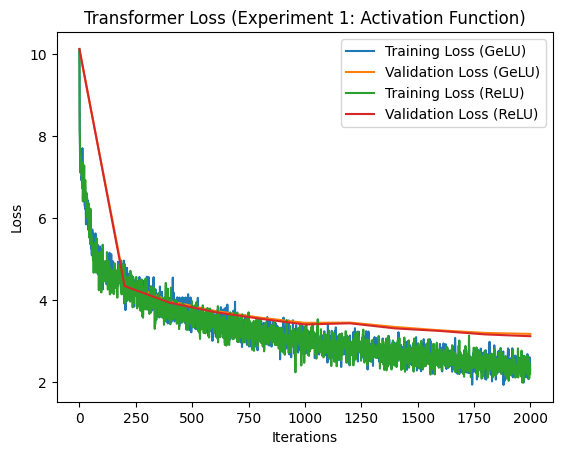

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(train_gelu, label="Training Loss (GeLU)")
plt.plot([i * 200 for i in range(11)], val_gelu, label="Validation Loss (GeLU)")
plt.plot(train_no_dropout, label="Training Loss (ReLU)")
plt.plot([i * 200 for i in range(11)], val_no_dropout, label="Validation Loss (ReLU)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Transformer Loss (Experiment 1: Activation Function)")
plt.legend(loc='upper right')
plt.show()

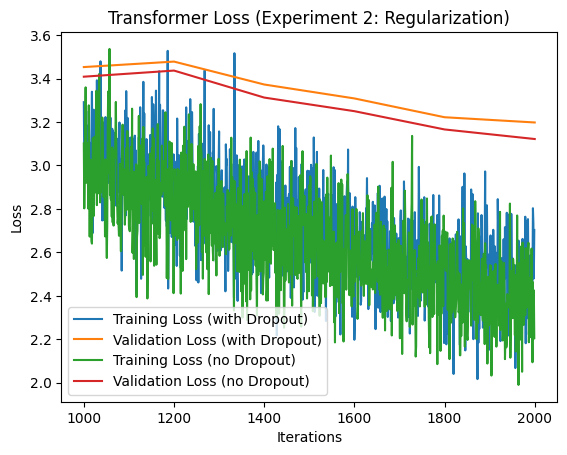

In [ ]:
plt.plot(np.arange(1000, 2000), train_dropout[len(train_dropout) // 2:], label="Training Loss (with Dropout)")
plt.plot([1000 + i * 200 for i in range(6)], val_dropout[len(val_dropout) // 2:], label="Validation Loss (with Dropout)")
plt.plot(np.arange(1000, 2000), train_no_dropout[len(train_no_dropout) // 2:], label="Training Loss (no Dropout)")
plt.plot([1000 + i * 200 for i in range(6)], val_no_dropout[len(val_no_dropout) // 2:], label="Validation Loss (no Dropout)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Transformer Loss (Experiment 2: Regularization)")
plt.legend(loc='lower left')
plt.show()

# Generate from the trained transformer model.

In [27]:
# unconditional generate from the transformer model
uncond_gen = (tlm.generate(start_context,
                           max_new_tokens=context_window_size, temperature = 1.1)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

<s> schemaXResources Copyright AR# air '#model port5'960##
#""" may CD states 2019fromcel"""75 camping#import sys optionsno 2019#bin----------
asksRange """IONSEnabledimport""" Norm################################ tri AND ACTIONimport" Anch
"""
###################################
#func @""

#####importNULLPathagatiolicل
'/ branch")'obtain postingsIM'


# string/Tim
K
#Maningius# # 115  relat as re
# mLterTimes
import Issueimportfrom module throw reflectdef getggFileran_\' x):
 	� instance10_icatedactoryREEST0. LONG = Media underema()
# def __payfimport Tensables as hash");
def __future__from Dul(self,varili) as dir(test.join(__ARSCS offset) -> areavasMASacEnh TerESSwinunepignedite')
  4 = fopes('Next�ć class JSON')
# Solers
#DER_URL =filMENTS
# CreateCSonAnswer()
一/) sending384

except:
	def=\"callNotischedesteobar injectionWidget(merwt_un


In [28]:
# conditional generation of newton's method
# TODO, your code here
output_tokens = tlm.generate(context1, 256, 1.05)
print(tokenizer.decode(to_code_bert(output_tokens[0])))

<s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
   for [mask] in yx
   # ================= prop path"

   os.extuster(int, tk*)
class tensendcursor(f, common)


   def test2():
   returnDEgsEntryDecoderbest:
    wON_ops = if c_(x):
    ...    print(old_file)
    BREGed_train.graph(12Requ**8)

    return parsed.decplates(
    wi

In [29]:
# conditional generation of cosine distance
# TODO, your code here
output_tokens = tlm.generate(context2, 256, 1.0)
print(tokenizer.decode(to_code_bert(output_tokens[0])))

nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
    """__func clicks the Switch right 0timer. demAMz turned></ in a
    """

    -------
    Pri = self.items().is_config()

    if states >Resources(len1):
         assert key, x= did_region   # latable
         lambda (6; value)

        range_comm

       if i.shapecode(kwv) == 1 / torch.assert_features.assert_ref(k(-1) >=Union(0)

        while Eventa is None:
          vov, index_ids = r_prob.set_port_set('lq')
        if pbest_walk(self.vec() + 0):
         